1. mon_standard.pkl > array code



In [32]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 95

# Load the pickle file
print("Loading datafile...")
with open("mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1_mon = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_mon = [] # Array to store instances (direction*size) - size information
y_mon = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)
size = len(y_mon)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 1900


2. unmon_standard10.pkl > array code

In [54]:
import pickle
import numpy as np

TOTAL_URLS = 300  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('unmon_standard10_3000.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1_unmon.append(np.array(time_seq, dtype=np.int32))
    X2_unmon.append(np.array(size_seq, dtype=np.int16))


print(len(X1_unmon)) # Print the length of X1

print(X2_unmon[0-10])

Loading datafile...
Total samples: 3000
300
[-512 -512  512 ... -512 -512 -512]


### Data Preprocessing ###

#### Remove corrupted/incomplete traces


In [34]:
def clean(X1, X2, y=None):
    X1_clean, X2_clean, y_clean = [], [], []
    for i in range(len(X1)):
        if len(X1[i]) > 0 and len(X1[i]) == len(X2[i]): # non-empty & matching lengths
            X1_clean.append(X1[i])
            X2_clean.append(X2[i])
            if y is not None:
                y_clean.append(y[i])
    return (X1_clean, X2_clean, y_clean) if y is not None else (X1_clean, X2_clean)

# clean monitored
X1_mon, X2_mon, y_mon = clean(X1_mon, X2_mon, y_mon)
print("Clean monitored traces:", len(X1_mon))

# clean unmonitored
X1_unmon, X2_unmon = clean(X1_unmon, X2_unmon)
print("Clean unmonitored traces:", len(X1_unmon))

Clean monitored traces: 1900
Clean unmonitored traces: 300


#### Normalize timestamps to start at 0

In [35]:
def normalize_timestamps(X1):
    return [[t - seq[0] for t in seq] for seq in X1] # subtract by first seq value for each value to see how much time passed in each packet

X1_mon = normalize_timestamps(X1_mon)
X1_unmon = normalize_timestamps(X1_unmon)

#### Truncate or pad sequences to certain length

In [36]:
import numpy as np

MAX_LEN = 10000

def pad_truncate(seq, max_len=10000):
    seq = list(seq)  # assure une liste Python

    if len(seq) > max_len:
        return seq[:max_len]

    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))

    return seq

# --- MONITORED --------------------------------------------------------------
X1_mon = np.array([pad_truncate(s, MAX_LEN) for s in X1_mon])
X2_mon = np.array([pad_truncate(s, MAX_LEN) for s in X2_mon])
y_mon = np.array(y_mon)

# --- UNMONITORED ------------------------------------------------------------
X1_unmon = np.array([pad_truncate(s, MAX_LEN) for s in X1_unmon])
X2_unmon = np.array([pad_truncate(s, MAX_LEN) for s in X2_unmon])

print("\nMonitored timestamps:", X1_mon.shape)
print("Unmonitored timestamps:", X1_unmon.shape)



Monitored timestamps: (1900, 10000)
Unmonitored timestamps: (300, 10000)


#### Split data into training, testing, and validation datasets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1) SCENARIO CLOSED WORLD

X1_train_cw, X1_temp_cw, X2_train_cw, X2_temp_cw, y_train_cw, y_temp_cw = train_test_split(
    X1_mon, X2_mon, y_mon,
    test_size=0.30,
    stratify=y_mon,
    random_state=42
)

X1_val_cw, X1_test_cw, X2_val_cw, X2_test_cw, y_val_cw, y_test_cw = train_test_split(
    X1_temp_cw, X2_temp_cw, y_temp_cw,
    test_size=0.50,
    stratify=y_temp_cw,
    random_state=42
)

# 2) SCENARIO OPEN WORLD (binary 0/1)

y_mon_binary = np.ones(len(X1_mon))        # Surveillé = 1
y_unmon_binary = np.zeros(len(X1_unmon))   # Non-surveillé = 0

# Combine les données
X1_all = np.vstack((X1_mon, X1_unmon))
X2_all = np.vstack((X2_mon, X2_unmon))
y_all  = np.concatenate((y_mon_binary, y_unmon_binary))

# Split open world
X1_train_ow, X1_temp_ow, X2_train_ow, X2_temp_ow, y_train_ow, y_temp_ow = train_test_split(
    X1_all, X2_all, y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=42
)

X1_val_ow, X1_test_ow, X2_val_ow, X2_test_ow, y_val_ow, y_test_ow = train_test_split(
    X1_temp_ow, X2_temp_ow, y_temp_ow,
    test_size=0.50,
    stratify=y_temp_ow,
    random_state=42
)

## **FEATURE EXTRACTION** (Alexandre)

In [55]:
import numpy as np
from collections import Counter

def extract_all_features(X1, X2):
    all_features = []
    
    for idx in range(len(X1)):
        # Remove padding (zeros)
        time_seq = X1[idx][X1[idx] != 0]
        size_seq = X2[idx][X2[idx] != 0]
        
        # Handle empty sequences
        if len(time_seq) == 0 or len(size_seq) == 0:
            # Return zero features for empty sequences
            all_features.append([0] * 80)
            continue
        
        feature_dict = {}
        
        # ====================================================================
        # 1. STATISTICAL FEATURES
        # ====================================================================
        
        # Basic counts
        feature_dict['total_packets'] = len(size_seq)
        feature_dict['incoming_packets'] = np.sum(size_seq < 0)
        feature_dict['outgoing_packets'] = np.sum(size_seq > 0)
        
        # Byte statistics
        feature_dict['total_bytes_in'] = np.sum(np.abs(size_seq[size_seq < 0]))
        feature_dict['total_bytes_out'] = np.sum(size_seq[size_seq > 0])
        feature_dict['total_bytes'] = np.sum(np.abs(size_seq))
        
        # Packet size statistics
        abs_sizes = np.abs(size_seq)
        feature_dict['mean_packet_size'] = np.mean(abs_sizes)
        feature_dict['std_packet_size'] = np.std(abs_sizes)
        feature_dict['median_packet_size'] = np.median(abs_sizes)
        feature_dict['max_packet_size'] = np.max(abs_sizes)
        feature_dict['min_packet_size'] = np.min(abs_sizes)
        
        # Ratios
        feature_dict['in_out_packet_ratio'] = (feature_dict['incoming_packets'] / max(feature_dict['outgoing_packets'], 1))
        feature_dict['in_out_byte_ratio'] = (feature_dict['total_bytes_in'] / max(feature_dict['total_bytes_out'], 1))
        
        # ====================================================================
        # 2. BURST FEATURES
        # ====================================================================
        
        # Identify bursts (consecutive packets in same direction)
        directions = np.sign(size_seq)
        direction_changes = np.concatenate([[True], np.diff(directions) != 0])
        burst_indices = np.where(direction_changes)[0]
        
        # Split into bursts
        bursts = np.split(size_seq, burst_indices[1:])
        burst_times = np.split(time_seq, burst_indices[1:])
        
        # Burst lengths (number of packets per burst)
        burst_lengths = [len(b) for b in bursts]
        
        # Burst sizes (total bytes per burst)
        burst_sizes = [np.sum(np.abs(b)) for b in bursts]
        
        # Burst durations (time span)
        burst_durations = []
        for bt in burst_times:
            if len(bt) > 1:
                burst_durations.append(bt[-1] - bt[0])
            else:
                burst_durations.append(0)
        
        # Burst statistics
        feature_dict['num_bursts'] = len(bursts)
        feature_dict['max_burst_length'] = np.max(burst_lengths) if burst_lengths else 0
        feature_dict['avg_burst_length'] = np.mean(burst_lengths) if burst_lengths else 0
        feature_dict['std_burst_length'] = np.std(burst_lengths) if len(burst_lengths) > 1 else 0
        
        feature_dict['max_burst_size'] = np.max(burst_sizes) if burst_sizes else 0
        feature_dict['avg_burst_size'] = np.mean(burst_sizes) if burst_sizes else 0
        feature_dict['std_burst_size'] = np.std(burst_sizes) if len(burst_sizes) > 1 else 0
        
        feature_dict['max_burst_duration'] = np.max(burst_durations) if burst_durations else 0
        feature_dict['avg_burst_duration'] = np.mean(burst_durations) if burst_durations else 0
        
        # Incoming vs outgoing bursts
        incoming_bursts = [b for b in bursts if b[0] < 0]
        outgoing_bursts = [b for b in bursts if b[0] > 0]
        
        feature_dict['num_incoming_bursts'] = len(incoming_bursts)
        feature_dict['num_outgoing_bursts'] = len(outgoing_bursts)
        
        # ====================================================================
        # 3. TIMING FEATURES
        # ====================================================================
        
        # Session duration
        feature_dict['session_duration'] = time_seq[-1] - time_seq[0]
        
        # Inter-packet delays
        if len(time_seq) > 1:
            inter_packet_delays = np.diff(time_seq)
            
            feature_dict['mean_delay'] = np.mean(inter_packet_delays)
            feature_dict['std_delay'] = np.std(inter_packet_delays)
            feature_dict['median_delay'] = np.median(inter_packet_delays)
            feature_dict['min_delay'] = np.min(inter_packet_delays)
            feature_dict['max_delay'] = np.max(inter_packet_delays)
            
            # Percentiles
            feature_dict['percentile_10_delay'] = np.percentile(inter_packet_delays, 10)
            feature_dict['percentile_25_delay'] = np.percentile(inter_packet_delays, 25)
            feature_dict['percentile_50_delay'] = np.percentile(inter_packet_delays, 50)
            feature_dict['percentile_75_delay'] = np.percentile(inter_packet_delays, 75)
            feature_dict['percentile_90_delay'] = np.percentile(inter_packet_delays, 90)
            
            # Time to first incoming packet
            first_incoming_idx = np.where(size_seq < 0)[0]
            if len(first_incoming_idx) > 0:
                feature_dict['time_to_first_incoming'] = time_seq[first_incoming_idx[0]]
            else:
                feature_dict['time_to_first_incoming'] = 0
        else:
            # Single packet - set timing features to 0
            for k in ['mean_delay', 'std_delay', 'median_delay', 'min_delay', 'max_delay',
                      'percentile_10_delay', 'percentile_25_delay', 'percentile_50_delay',
                      'percentile_75_delay', 'percentile_90_delay', 'time_to_first_incoming']:
                feature_dict[k] = 0
        
        # ====================================================================
        # 4. DIRECTIONAL PATTERN FEATURES
        # ====================================================================
        
        # Number of direction changes
        feature_dict['direction_changes'] = np.sum(direction_changes) - 1  # -1 because first is always True
        
        # Average length of unidirectional sequences (same as avg burst length)
        feature_dict['avg_unidirectional_length'] = feature_dict['avg_burst_length']
        
        # First outgoing burst characteristics
        if len(outgoing_bursts) > 0:
            feature_dict['first_outgoing_burst_size'] = np.sum(outgoing_bursts[0])
            feature_dict['first_outgoing_burst_length'] = len(outgoing_bursts[0])
        else:
            feature_dict['first_outgoing_burst_size'] = 0
            feature_dict['first_outgoing_burst_length'] = 0
        
        # Traffic concentration (packets in first/last 20%)
        split_20 = len(size_seq) // 5
        split_80 = (4 * len(size_seq)) // 5
        
        feature_dict['packets_first_20_percent'] = split_20
        feature_dict['packets_last_20_percent'] = len(size_seq) - split_80
        
        # Ratio of outgoing to incoming in different segments
        # Beginning (first 30%)
        split_30 = len(size_seq) // 3
        early_out = np.sum(size_seq[:split_30] > 0)
        early_in = np.sum(size_seq[:split_30] < 0)
        feature_dict['early_out_in_ratio'] = early_out / max(early_in, 1)
        
        # Middle (30%-70%)
        split_70 = (7 * len(size_seq)) // 10
        mid_out = np.sum(size_seq[split_30:split_70] > 0)
        mid_in = np.sum(size_seq[split_30:split_70] < 0)
        feature_dict['mid_out_in_ratio'] = mid_out / max(mid_in, 1)
        
        # End (last 30%)
        late_out = np.sum(size_seq[split_70:] > 0)
        late_in = np.sum(size_seq[split_70:] < 0)
        feature_dict['late_out_in_ratio'] = late_out / max(late_in, 1)
        
        # ====================================================================
        # 5. SEQUENCE-BASED FEATURES
        # ====================================================================
        
        # First K packet directions (K=20)
        K = 20
        first_k_directions = directions[:min(K, len(directions))]
        
        # Count patterns in first K
        feature_dict['first_k_incoming'] = np.sum(first_k_directions == -1)
        feature_dict['first_k_outgoing'] = np.sum(first_k_directions == 1)
        
        # N-grams of directional patterns (bigrams and trigrams)
        # Convert directions to string for n-gram extraction
        dir_string = ''.join(['O' if d > 0 else 'I' for d in directions])
        
        # Bigrams (pairs)
        if len(dir_string) >= 2:
            bigrams = [dir_string[i:i+2] for i in range(len(dir_string)-1)]
            bigram_counts = Counter(bigrams)
            
            feature_dict['bigram_OO'] = bigram_counts.get('OO', 0)
            feature_dict['bigram_OI'] = bigram_counts.get('OI', 0)
            feature_dict['bigram_IO'] = bigram_counts.get('IO', 0)
            feature_dict['bigram_II'] = bigram_counts.get('II', 0)
        else:
            feature_dict['bigram_OO'] = 0
            feature_dict['bigram_OI'] = 0
            feature_dict['bigram_IO'] = 0
            feature_dict['bigram_II'] = 0
        
        # Trigrams (triples)
        if len(dir_string) >= 3:
            trigrams = [dir_string[i:i+3] for i in range(len(dir_string)-2)]
            trigram_counts = Counter(trigrams)
            
            feature_dict['trigram_OOO'] = trigram_counts.get('OOO', 0)
            feature_dict['trigram_III'] = trigram_counts.get('III', 0)
            feature_dict['trigram_OOI'] = trigram_counts.get('OOI', 0)
            feature_dict['trigram_IOO'] = trigram_counts.get('IOO', 0)
        else:
            feature_dict['trigram_OOO'] = 0
            feature_dict['trigram_III'] = 0
            feature_dict['trigram_OOI'] = 0
            feature_dict['trigram_IOO'] = 0
        
        if feature_dict['session_duration'] > 0:
            num_windows = 10
            window_size = feature_dict['session_duration'] / num_windows
            cumulative_bytes = np.zeros(num_windows)
            
            for i, t in enumerate(time_seq):
                window_idx = min(int(t / window_size), num_windows - 1)
                cumulative_bytes[window_idx] += abs(size_seq[i])
            
            # Normalize cumulative bytes
            if np.sum(cumulative_bytes) > 0:
                cumulative_bytes = cumulative_bytes / np.sum(cumulative_bytes)
            
            for i in range(num_windows):
                feature_dict[f'cumulative_bytes_window_{i}'] = cumulative_bytes[i]
        else:
            for i in range(10):
                feature_dict[f'cumulative_bytes_window_{i}'] = 0
        
        # Convert to list
        all_features.append(list(feature_dict.values()))
    
    # Get feature names from the first non-empty sample
    feature_names = list(feature_dict.keys())
    
    return np.array(all_features), feature_names

In [56]:
from sklearn.preprocessing import StandardScaler

print("Extracting features...")

# CLOSED WORLD
X_train_cw_features, feature_names = extract_all_features(X1_train_cw, X2_train_cw)
X_val_cw_features, _ = extract_all_features(X1_val_cw, X2_val_cw)
X_test_cw_features, _ = extract_all_features(X1_test_cw, X2_test_cw)

# OPEN WORLD
X_train_ow_features, _ = extract_all_features(X1_train_ow, X2_train_ow)
X_val_ow_features, _ = extract_all_features(X1_val_ow, X2_val_ow)
X_test_ow_features, _ = extract_all_features(X1_test_ow, X2_test_ow)

print(f"✓ {len(feature_names)} features extracted")

# SCALING
scaler_cw = StandardScaler()
X_train_cw_scaled = scaler_cw.fit_transform(X_train_cw_features)
X_val_cw_scaled = scaler_cw.transform(X_val_cw_features)
X_test_cw_scaled = scaler_cw.transform(X_test_cw_features)

scaler_ow = StandardScaler()
X_train_ow_scaled = scaler_ow.fit_transform(X_train_ow_features)
X_val_ow_scaled = scaler_ow.transform(X_val_ow_features)
X_test_ow_scaled = scaler_ow.transform(X_test_ow_features)

print("✓ Features scaled")

Extracting features...
✓ 65 features extracted
✓ Features scaled


## **KNN MODEL** (Alice)

In [59]:
from sklearn.preprocessing import StandardScaler

# --- Closed World Scaler ---
scaler_cw = StandardScaler()

# Fit only on CW training features
scaler_cw.fit(X_train_cw_features)

# Transform
X_train_cw_scaled = scaler_cw.transform(X_train_cw_features)
X_val_cw_scaled   = scaler_cw.transform(X_val_cw_features)
X_test_cw_scaled  = scaler_cw.transform(X_test_cw_features)

# --- Open World Scaler ---
scaler_ow = StandardScaler()

# Fit only on OW training features
scaler_ow.fit(X_train_ow_features)

# Transform
X_train_ow_scaled = scaler_ow.transform(X_train_ow_features)
X_val_ow_scaled   = scaler_ow.transform(X_val_ow_features)
X_test_ow_scaled  = scaler_ow.transform(X_test_ow_features)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("=== CLOSED WORLD====")

# KNN model
knn_cw = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Train
knn_cw.fit(X_train_cw_scaled, y_train_cw)

# Validation accuracy
y_train_pred_cw = knn_cw.predict(X_train_cw_scaled)
y_val_pred_cw  = knn_cw.predict(X_val_cw_scaled)
y_test_pred_cw = knn_cw.predict(X_test_cw_scaled)


# Test accuracy
train_acc_cw = accuracy_score(y_train_cw, y_train_pred_cw)
val_acc_cw   = accuracy_score(y_val_cw, y_val_pred_cw)
test_acc_cw  = accuracy_score(y_test_cw, y_test_pred_cw)


print("Train accuracy       :", train_acc_cw)
print("Validation accuracy  :", val_acc_cw)
print("Test accuracy        :", test_acc_cw)

=== CLOSED WORLD====
Train accuracy       : 0.9180451127819549
Validation accuracy  : 0.8456140350877193
Test accuracy        : 0.8140350877192982


### Closed world K-NN Hyperparameter Tuning

In [61]:
from sklearn.model_selection import GridSearchCV

print("\n--- CLOSED WORLD K-NN OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],       # Test different neighbors
    'weights': ['uniform', 'distance'] # Test weight modes
}

# 2. Run the search (cv=3 for faster execution)
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, n_jobs=-1, verbose=1)
grid_knn.fit(X_train_cw_scaled, y_train_cw)

# 3. Retrieve the best model
best_knn_cw = grid_knn.best_estimator_
tuned_acc_cw = best_knn_cw.score(X_test_cw_scaled, y_test_cw)

print(f"\nBest parameters found    : {grid_knn.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_cw:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_cw:.4f}")

# 4. Display the gain
gain = tuned_acc_cw - test_acc_cw
if gain > 0:
    print(f"IMPROVEMENT: +{gain:.4f}")
else:
    print(f"🔹 No significant improvement (default model was already good).")


--- CLOSED WORLD K-NN OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found    : {'n_neighbors': 3, 'weights': 'distance'}
Accuracy WITHOUT tuning  : 0.8140
Accuracy WITH tuning     : 0.8351
IMPROVEMENT: +0.0211


### Comparaison KNN closed world without and with Hyperparameter Tuninh

In [64]:
print("\n=== OPEN WORLD (binary 0=unmon, 1=mon) ===")

# KNN model
knn_ow = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Train
knn_ow.fit(X_train_ow_scaled, y_train_ow)

y_train_pred_ow = knn_ow.predict(X_train_ow_scaled)
y_val_pred_ow   = knn_ow.predict(X_val_ow_scaled)
y_test_pred_ow  = knn_ow.predict(X_test_ow_scaled)

# --- Calcul accuracy ---
train_acc_ow = accuracy_score(y_train_ow, y_train_pred_ow)
val_acc_ow   = accuracy_score(y_val_ow, y_val_pred_ow)
test_acc_ow  = accuracy_score(y_test_ow, y_test_pred_ow)


print("Train accuracy       :", train_acc_ow)
print("Validation accuracy  :", val_acc_ow)
print("Test accuracy        :", test_acc_ow)



=== OPEN WORLD (binary 0=unmon, 1=mon) ===
Train accuracy       : 0.9668831168831169
Validation accuracy  : 0.9575757575757575
Test accuracy        : 0.9515151515151515


### Open world K-NN Hyperparameter Tuning

In [68]:
from sklearn.model_selection import GridSearchCV

print("\n--- OPEN WORLD K-NN OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],       # Test different neighbors
    'weights': ['uniform', 'distance'] # Test weight modes
}

# 2. Run the search (cv=3 for faster execution)
# Note: We use the Open World variables (_ow) here
grid_knn_ow = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, n_jobs=-1, verbose=1)
grid_knn_ow.fit(X_train_ow_scaled, y_train_ow)

# 3. Retrieve the best model
best_knn_ow = grid_knn_ow.best_estimator_
tuned_acc_ow = best_knn_ow.score(X_test_ow_scaled, y_test_ow)

print(f"\nBest parameters found    : {grid_knn_ow.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_ow:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_ow:.4f}")

# 4. Display the gain
gain_ow = tuned_acc_ow - test_acc_ow
if gain_ow > 0:
    print(f"IMPROVEMENT: +{gain_ow:.4f}")
else:
    print(f"No significant improvement (default model was already good).")


--- OPEN WORLD K-NN OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found    : {'n_neighbors': 3, 'weights': 'uniform'}
Accuracy WITHOUT tuning  : 0.9515
Accuracy WITH tuning     : 0.9515
No significant improvement (default model was already good).


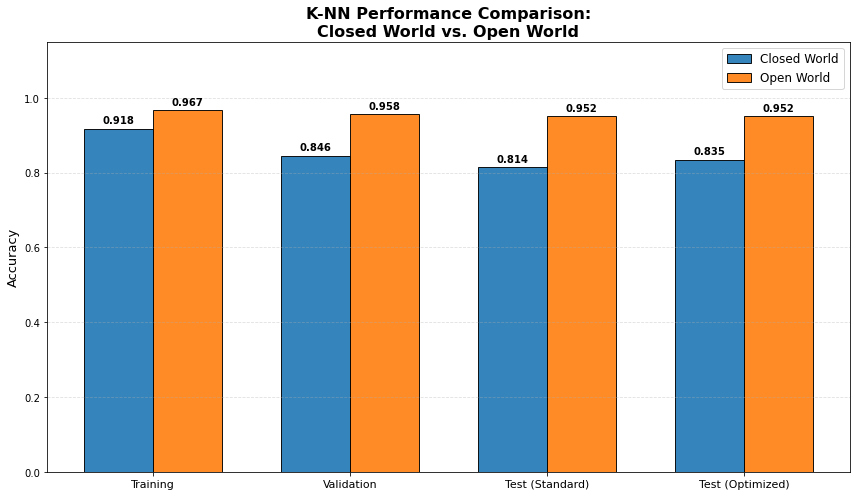

In [66]:
# --- COMPARATIVE VISUALIZATION: CLOSED WORLD VS OPEN WORLD (K-NN) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
# Categories
categories = ['Training', 'Validation', 'Test (Standard)', 'Test (Optimized)']

# Retrieve values (Make sure all these variables are defined in your previous cells)
cw_scores = [train_acc_cw, val_acc_cw, test_acc_cw, tuned_acc_cw]
ow_scores = [train_acc_ow, val_acc_ow, test_acc_ow, tuned_acc_ow]

# 2. Setup the bar chart positions
x = np.arange(len(categories))  # Label locations
width = 0.35                    # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# 3. Create the bars
# We shift the CW bars to the left and OW bars to the right of the center tick
rects1 = ax.bar(x - width/2, cw_scores, width, label='Closed World', color='#1f77b4', edgecolor='black', alpha=0.9)
rects2 = ax.bar(x + width/2, ow_scores, width, label='Open World', color='#ff7f0e', edgecolor='black', alpha=0.9)

# 4. Add text, labels, and title
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('K-NN Performance Comparison:\nClosed World vs. Open World', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.15) # Add headroom for labels
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Function to attach a label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 6. Show graph
plt.tight_layout()
plt.show()

## **SVM (Alice)**

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

print("=== CLOSED WORLD (SVM) ====")

svm_cw = SVC(
    kernel='rbf',
    gamma='scale',
    C=1.0,
    random_state=42,
    verbose=True
)

# --- Training ---
start_time = time.time()
print("Démarrage de l'entraînement...")
svm_cw.fit(X_train_cw_scaled, y_train_cw)
end_time = time.time()
print(f"Temps d'entraînement: {end_time - start_time:.2f} secondes")

# --- Predictions ---
y_train_pred_cw = svm_cw.predict(X_train_cw_scaled) # Training
y_val_pred_cw   = svm_cw.predict(X_val_cw_scaled)   # Validation
y_test_pred_cw  = svm_cw.predict(X_test_cw_scaled)  # Test

# --- Calcul accuracy ---
train_acc_cw = accuracy_score(y_train_cw, y_train_pred_cw)
val_acc_cw   = accuracy_score(y_val_cw, y_val_pred_cw)
test_acc_cw  = accuracy_score(y_test_cw, y_test_pred_cw)


print("\n--- RÉSULTATS ---")
print("Train accuracy       :", train_acc_cw)
print("Validation accuracy  :", val_acc_cw)
print("Test accuracy        :", test_acc_cw)

=== CLOSED WORLD (SVM) ====
Démarrage de l'entraînement...
[LibSVM]Temps d'entraînement: 0.14 secondes

--- RÉSULTATS ---
Train accuracy       : 0.8744360902255639
Validation accuracy  : 0.8035087719298246
Test accuracy        : 0.775438596491228


### Closed world SVM Hyperparameter Tuning

In [70]:
from sklearn.model_selection import GridSearchCV

print("\n--- CLOSED WORLD SVM OPTIMIZATION (GRID SEARCH) ---")

# 1. Define parameters to test
# We limit the grid because SVM is computationally expensive on large data
param_grid_svm = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['rbf'] 
}

# 2. Run the search
grid_svm_cw = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm_cw.fit(X_train_cw_scaled, y_train_cw)

# 3. Retrieve the best model
best_svm_cw = grid_svm_cw.best_estimator_
tuned_acc_cw = best_svm_cw.score(X_test_cw_scaled, y_test_cw)

print(f"\nBest parameters found    : {grid_svm_cw.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_cw:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_cw:.4f}")

# 4. Display the gain
gain_cw = tuned_acc_cw - test_acc_cw
if gain_cw > 0:
    print(f"IMPROVEMENT: +{gain_cw:.4f}")
else:
    print(f"No significant improvement.")


--- CLOSED WORLD SVM OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters found    : {'C': 100, 'kernel': 'rbf'}
Accuracy WITHOUT tuning  : 0.7754
Accuracy WITH tuning     : 0.8772
IMPROVEMENT: +0.1018


In [71]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

print("=== OPEN WORLD (SVM) ====")

svm_ow = SVC(
    kernel='rbf',
    gamma='scale',
    C=1.0,
    random_state=42,
    verbose=True
)

# --- Training ---
start_time = time.time()
print("Démarrage de l'entraînement...")
svm_ow.fit(X_train_ow_scaled, y_train_ow)
end_time = time.time()
print(f"Temps d'entraînement: {end_time - start_time:.2f} secondes")

# --- Predictions ---
y_train_pred_ow = svm_ow.predict(X_train_ow_scaled) # Training
y_val_pred_ow   = svm_ow.predict(X_val_ow_scaled)   # Validation
y_test_pred_ow  = svm_ow.predict(X_test_ow_scaled)  # Test

# --- Calcul accuracy ---
train_acc_ow = accuracy_score(y_train_ow, y_train_pred_ow)
val_acc_ow   = accuracy_score(y_val_ow, y_val_pred_ow)
test_acc_ow  = accuracy_score(y_test_ow, y_test_pred_ow)


print("\n--- RÉSULTATS ---")
print("Train accuracy       :", train_acc_ow)
print("Validation accuracy  :", val_acc_ow)
print("Test accuracy        :", test_acc_ow)


=== OPEN WORLD (SVM) ====
Démarrage de l'entraînement...
[LibSVM]Temps d'entraînement: 0.05 secondes

--- RÉSULTATS ---
Train accuracy       : 0.9961038961038962
Validation accuracy  : 0.9848484848484849
Test accuracy        : 0.9939393939393939


### Open world SVM Hyperparameter Tuning

In [72]:
from sklearn.model_selection import GridSearchCV

print("\n--- OPEN WORLD SVM OPTIMIZATION (GRID SEARCH) ---")
print("Warning: This process might be slow...")

# 1. Define parameters to test
# We use a limited grid to keep computation time reasonable
param_grid_svm = {
    'C': [0.1, 1, 10],   # Regularization parameter
    'kernel': ['rbf']    # RBF is usually best for this task
}

# 2. Run the search
# cv=3 is used for speed. n_jobs=-1 uses all CPU cores.
grid_svm_ow = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm_ow.fit(X_train_ow_scaled, y_train_ow)

# 3. Retrieve the best model
best_svm_ow = grid_svm_ow.best_estimator_
tuned_acc_ow = best_svm_ow.score(X_test_ow_scaled, y_test_ow)

print(f"\nBest parameters found    : {grid_svm_ow.best_params_}")
print(f"Accuracy WITHOUT tuning  : {test_acc_ow:.4f}")
print(f"Accuracy WITH tuning     : {tuned_acc_ow:.4f}")

# 4. Display the gain
gain_ow = tuned_acc_ow - test_acc_ow
if gain_ow > 0:
    print(f"IMPROVEMENT: +{gain_ow:.4f}")
else:
    print(f"No significant improvement.")


--- OPEN WORLD SVM OPTIMIZATION (GRID SEARCH) ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters found    : {'C': 1, 'kernel': 'rbf'}
Accuracy WITHOUT tuning  : 0.9939
Accuracy WITH tuning     : 0.9939
No significant improvement.


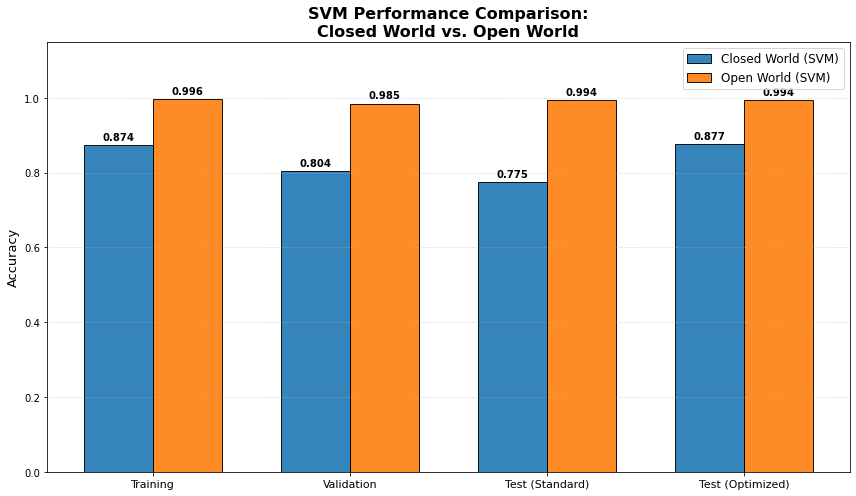

In [73]:
# --- COMPARATIVE VISUALIZATION: CLOSED WORLD VS OPEN WORLD (SVM) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
# Categories
categories = ['Training', 'Validation', 'Test (Standard)', 'Test (Optimized)']

# Retrieve values (Ensure you have run the SVM GridSearch blocks before this)
# If you haven't run the tuning, these variables (tuned_*) might be missing
cw_scores_svm = [train_acc_cw, val_acc_cw, test_acc_cw, tuned_acc_cw]
ow_scores_svm = [train_acc_ow, val_acc_ow, test_acc_ow, tuned_acc_ow]

# 2. Setup the bar chart positions
x = np.arange(len(categories))  # Label locations
width = 0.35                    # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# 3. Create the bars
# Closed World (Blue)
rects1 = ax.bar(x - width/2, cw_scores_svm, width, label='Closed World (SVM)', color='#1f77b4', edgecolor='black', alpha=0.9)
# Open World (Orange)
rects2 = ax.bar(x + width/2, ow_scores_svm, width, label='Open World (SVM)', color='#ff7f0e', edgecolor='black', alpha=0.9)

# 4. Add text, labels, and title
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('SVM Performance Comparison:\nClosed World vs. Open World', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.15) # Add headroom for labels
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Function to attach a label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 6. Show graph
plt.tight_layout()
plt.show()